In [ ]:
import sys
!rm -rf thesis
!git clone --branch master https://github.com/mattalejo/thesis

Cloning into 'thesis'...
remote: Enumerating objects: 1309, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 1309 (delta 40), reused 36 (delta 36), pack-reused 1267
Receiving objects: 100% (1309/1309), 105.00 MiB | 32.82 MiB/s, done.
Resolving deltas: 100% (434/434), done.


In [ ]:
sys.path.append("/content/thesis/")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sys.path.append("/content/drive/MyDrive/results")

# Import libraries

In [ ]:
import yfinance as yf
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import math as m

from sklearn.preprocessing import StandardScaler
# from tensorboard_logger import configure

import copy
import sys
import os

import prep_data
import train

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader, TensorDataset

from models.transformer import Transformer
from models.rnn import RNN
from models.transformer_encoder import TransformerEncoder

In [ ]:
if torch.cuda.is_available():
 dev = "cuda:0"
else:
 dev = "cpu"
device = torch.device(dev)

print(dev)

cuda:0


# Load data from `yfinance`

In [ ]:
BATCH_SIZE = [512]
DROPOUT = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

for batch_size in BATCH_SIZE:
  for dropout in DROPOUT:
    MODELS = [Transformer(dropout=dropout, embed_mode="t2v"), RNN(dropout=dropout)]
    MODEL_NAME = ["transformer","rnn"]
    for models, model_name in zip(MODELS, MODEL_NAME):
        model, best_model, loss, train_pred, test_pred, _ = train.train(
            model=models,
            seq_len=128,
            horizon=1,
            max_epoch=1000,
            batch_size=batch_size,
            loss=nn.MSELoss(),
            optimizer=optim.Adam,
            lr=1e-4,
            device=dev
        )
        config = f"updated_{model_name}_batchsize-{batch_size}_dropout-{dropout}"
        folder = f"/content/drive/MyDrive/results/updated/{config}"
        os.mkdir(folder)
        os.chdir(folder)
        torch.save(model, f"model_{config}.pth")
        torch.save(best_model, f"best_model_{config}.pth")
        loss.to_csv(f"metadata_{config}.csv")
        train_pred.to_csv(f"results_train_{config}.csv")
        test_pred.to_csv(f"results_test_{config}.csv")

In [ ]:
DROPOUT = [0.1, 0.2, 0.3, 0.4, 0.5 0.6]
MODELS = ["transformer", "rnn"]
TRAIN_TEST = ["train", "test"]
STRESS = ["gfc", "covid"]
BINS = [0.005*i for i in range(-20,20)]
COLORS = ["blue", "orange"]

for dropout in DROPOUT:
  for models in MODELS:
    config = f"updated_{models}_batchsize-512_dropout-{dropout}"
    os.chdir(f"/content/drive/MyDrive/results/updated/{config}")
    for train_test in TRAIN_TEST:
      df = pd.read_csv(f"results_{train_test}_{config}.csv")
      plt.figure(figsize=(10, 5), dpi=300)
      plt.hist(df[["y", "epoch_999"]], bins=BINS, density=True, histtype='bar', stacked=True)
      plt.title(f"{train_test} set distribution, truth vs. prediction (model={models})")
      plt.axis(ymin=0, ymax=100)
      plt.legend(["y", "epoch_999"])
      plt.savefig(f"hist_{train_test}_{config}.png")
    for stress in STRESS:
      df = pd.read_csv(f"stress_test_{stress}_{config}.csv")
      plt.figure(figsize=(10, 5), dpi=300)
      plt.hist(df[["y", "pred"]], bins=BINS, density=True, histtype='bar', stacked=True)
      plt.title(f"{stress} stress test distribution, truth vs. prediction (model={models})")
      plt.axis(ymin=0, ymax=100)
      plt.legend(["y", "pred"])
      plt.savefig(f"hist_{stress}_{config}.png")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

train | transformer | 0.1 | loss={'mse': 0.0020786093082278967, 'mae': 0.030084753409028053, 'mape': 1.3058511018753052, 'rmse': 0.04559176787734032, 'accuracy': {'bau': 0.9845995903015137, 'ffill': 0.9845996499061584}}



[*********************100%%**********************]  1 of 1 completed

test | transformer | 0.1 | loss={'mse': 0.5645129084587097, 'mae': 0.5043104887008667, 'mape': 10.276630401611328, 'rmse': 0.7513407468795776, 'accuracy': {'bau': 0.6753424406051636, 'ffill': 0.6753425002098083}}



[*********************100%%**********************]  1 of 1 completed

gfc | transformer | 0.1 | loss={'mse': 0.4976973235607147, 'mae': 0.3651783764362335, 'mape': 5.232486724853516, 'rmse': 0.7054766416549683, 'accuracy': {'bau': 0.6338797807693481, 'ffill': 0.6338797807693481}}


covid | transformer | 0.1 | loss={'mse': 1.8649691343307495, 'mae': 0.8896355628967285, 'mape': 11.98983097076416, 'rmse': 1.3656387329101562, 'accuracy': {'bau': 0.8010948896408081, 'ffill': 0.8010948896408081}}


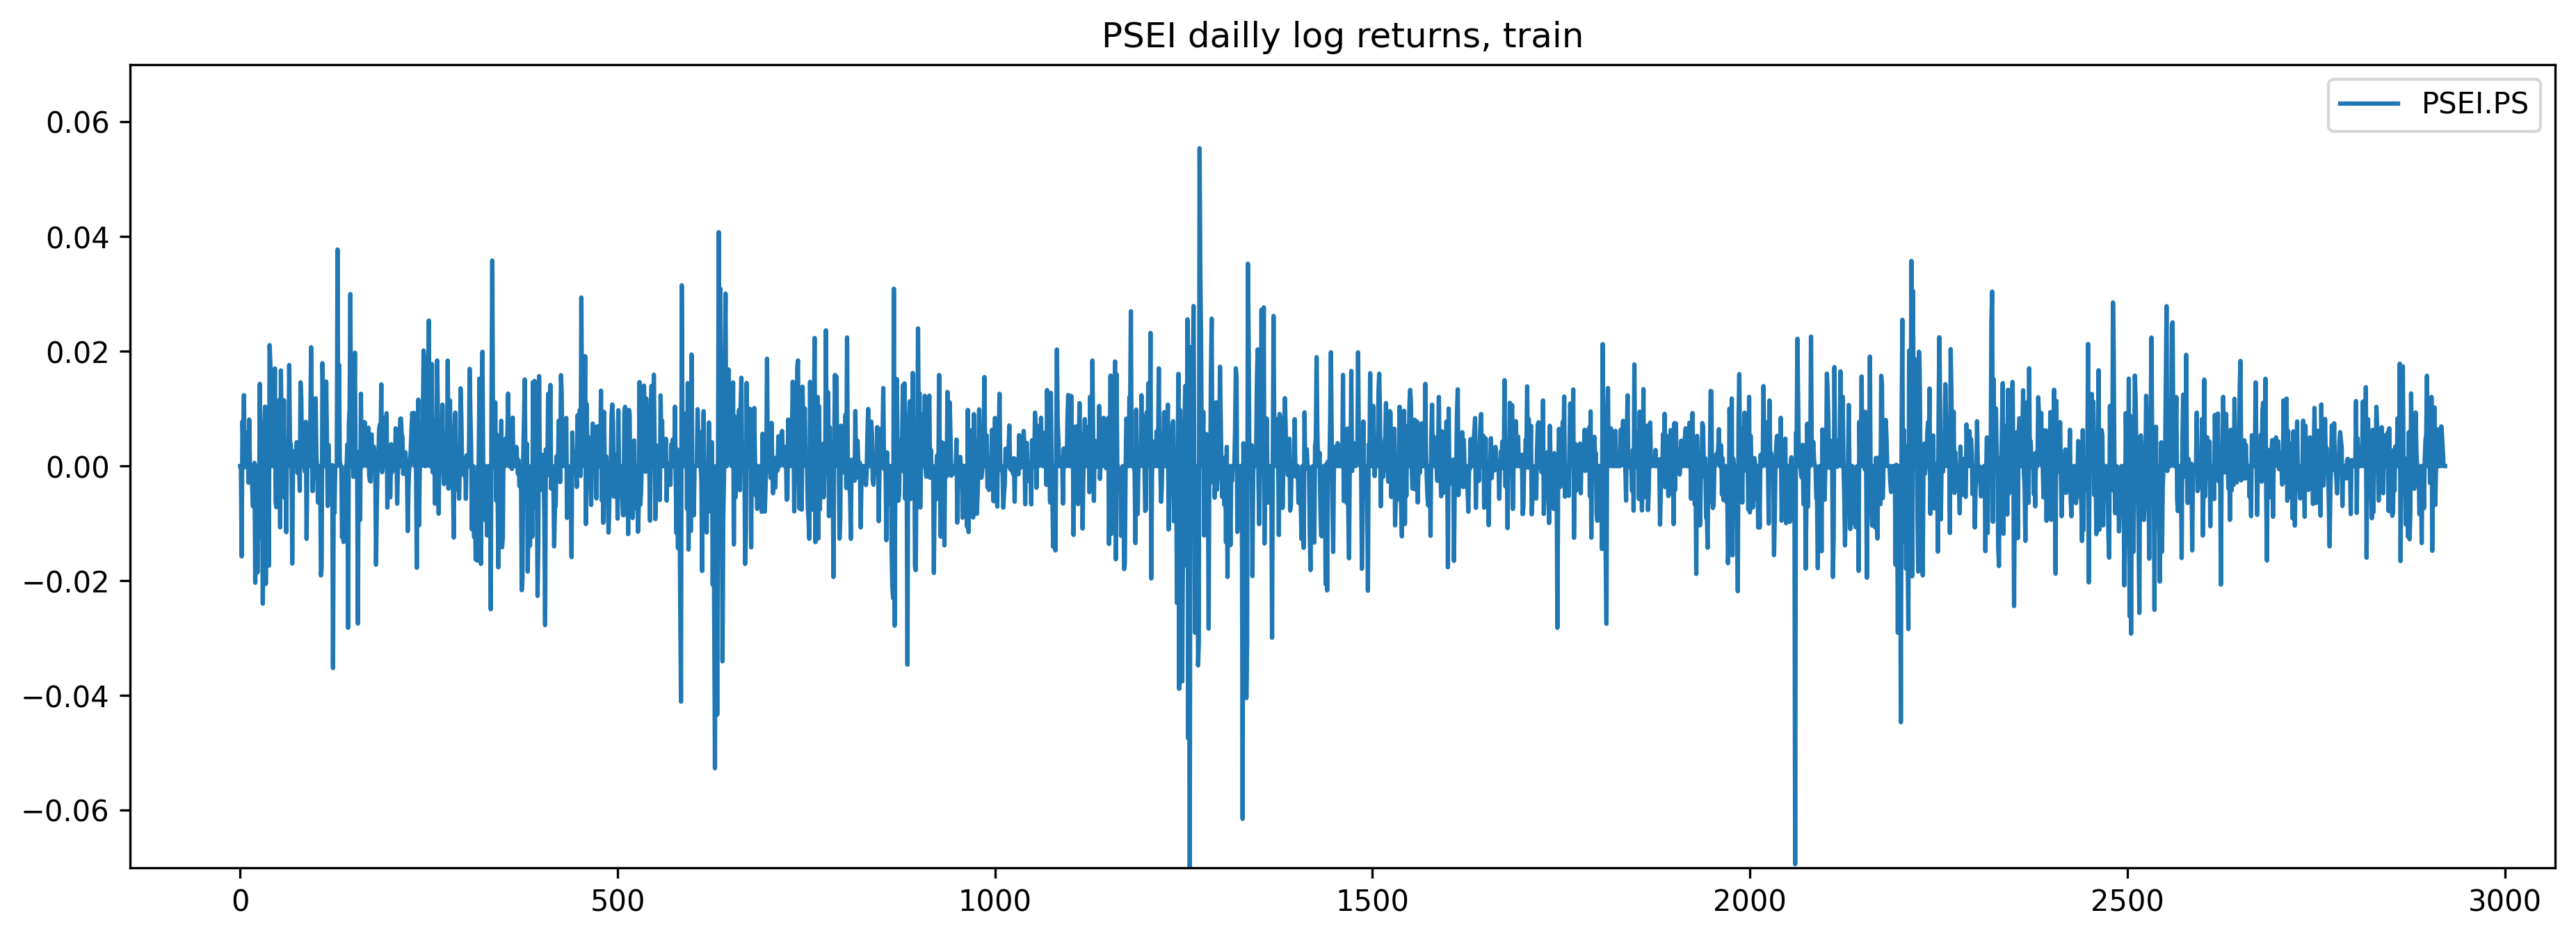

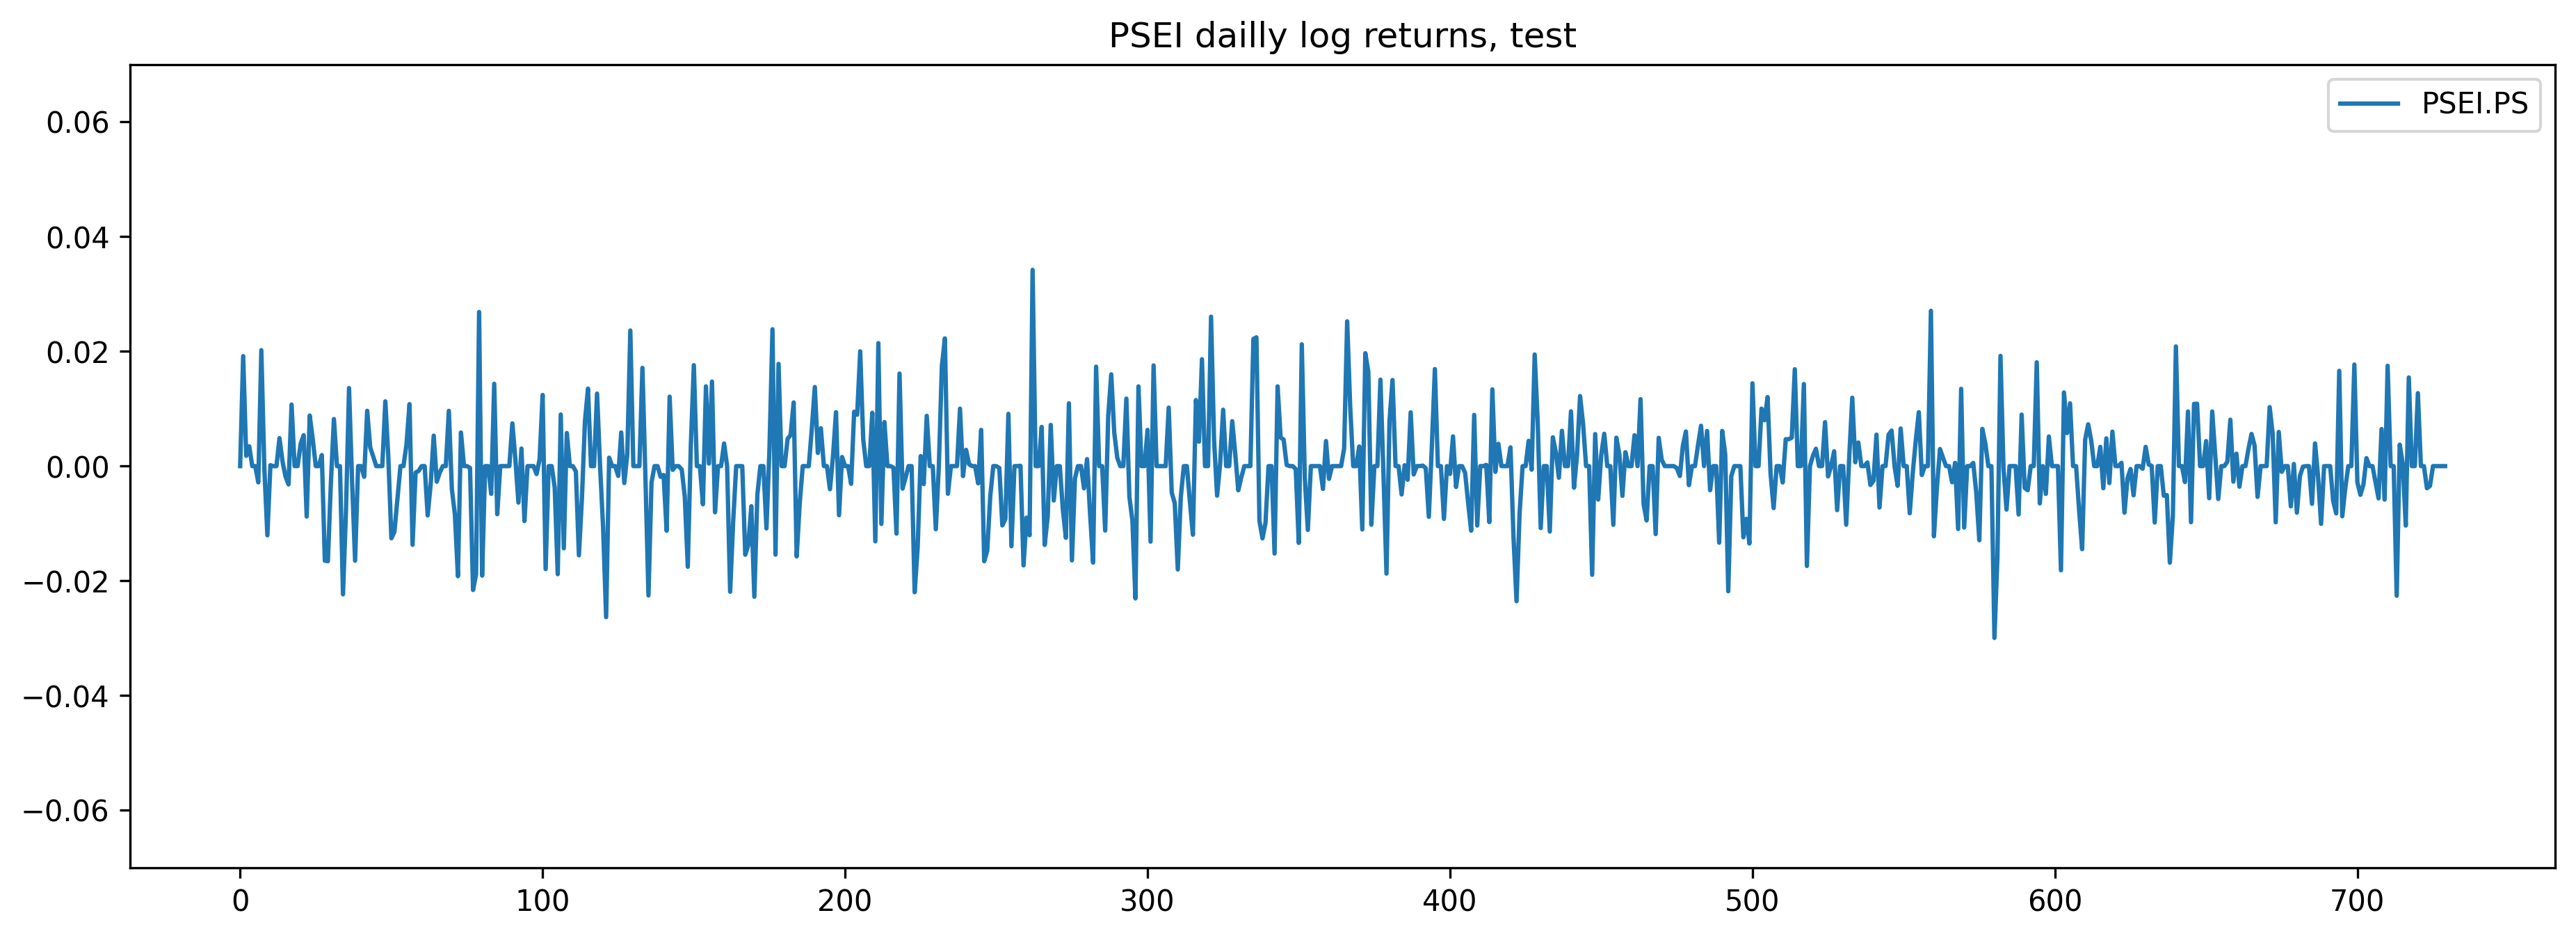

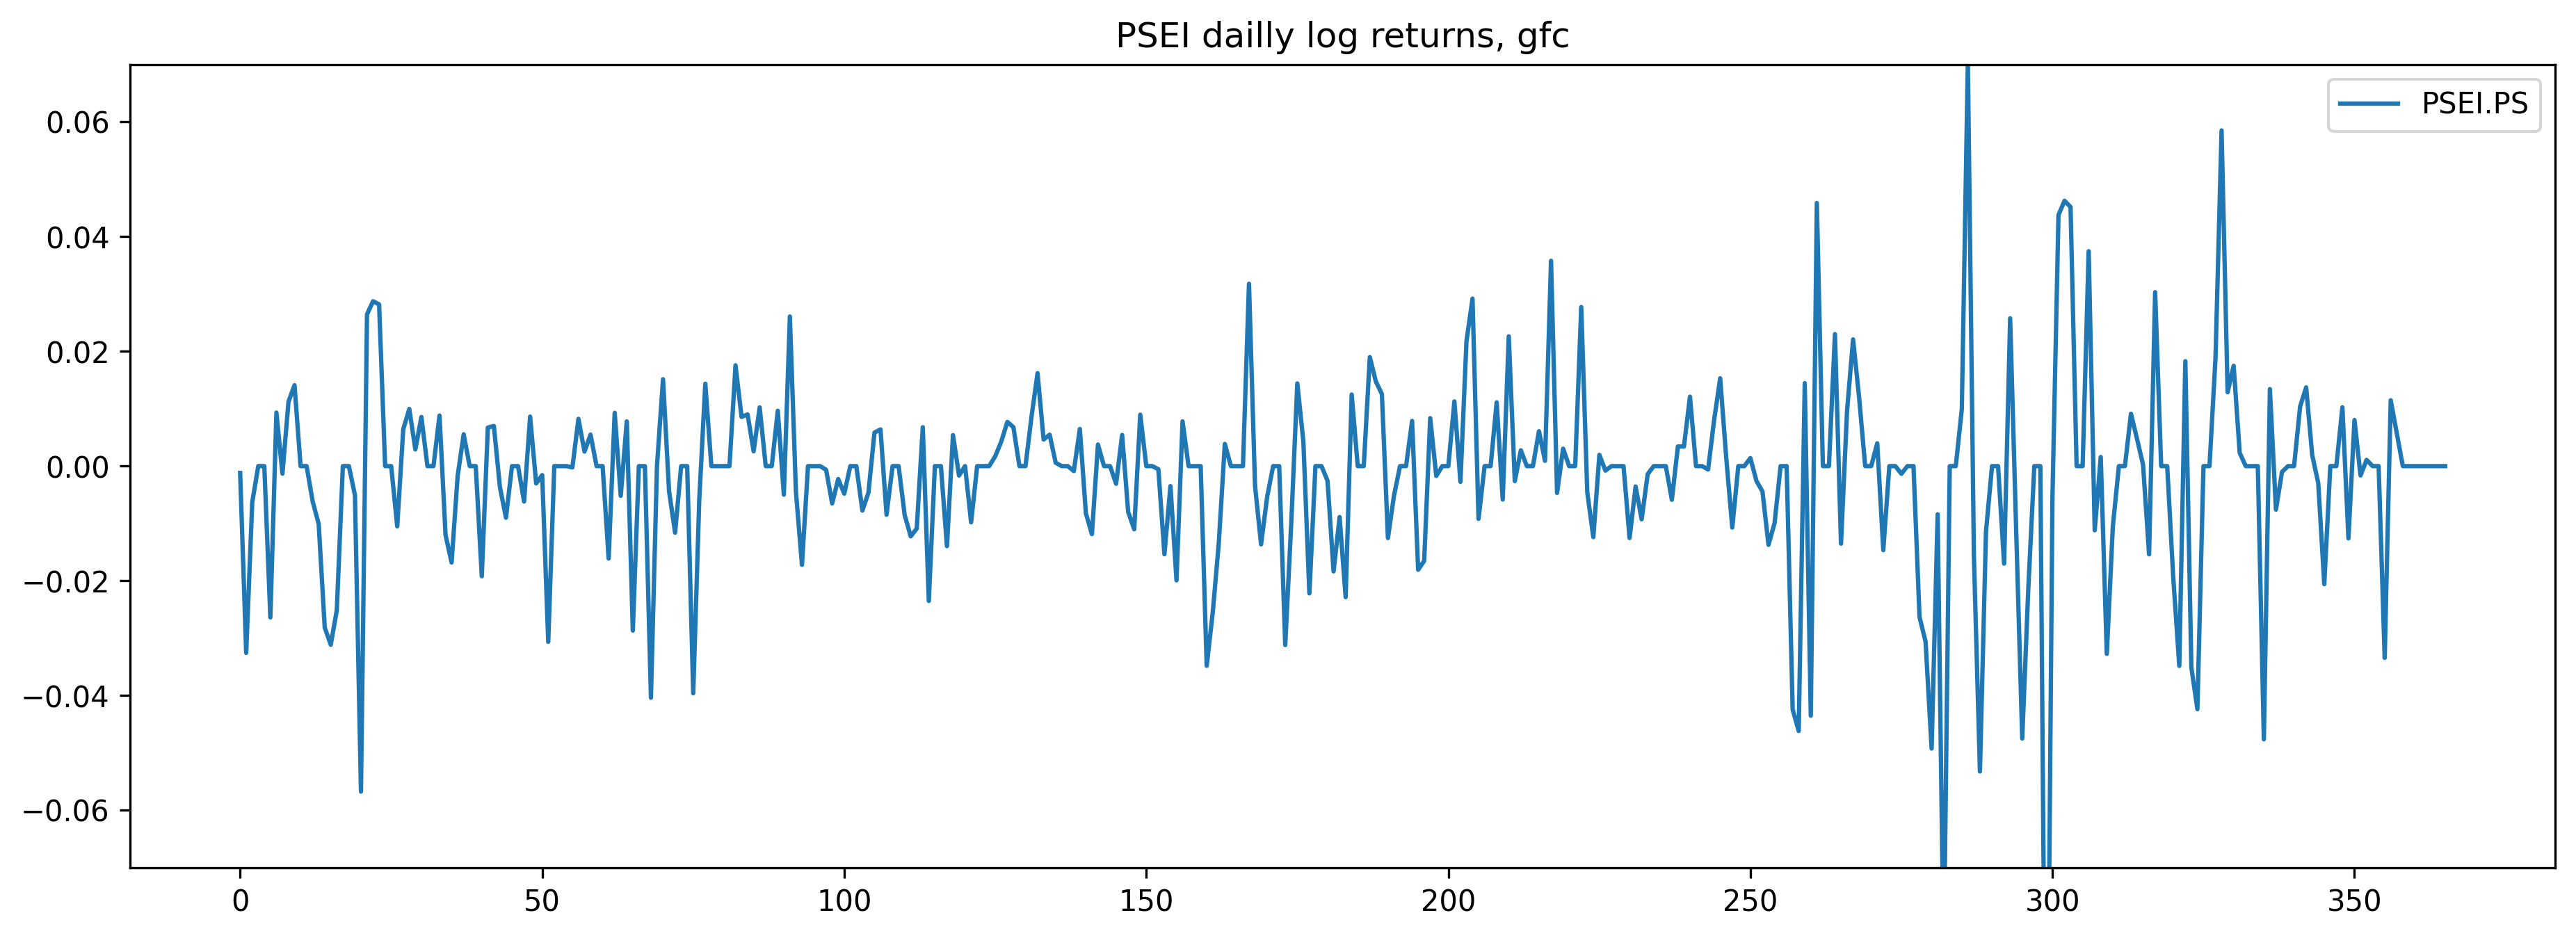

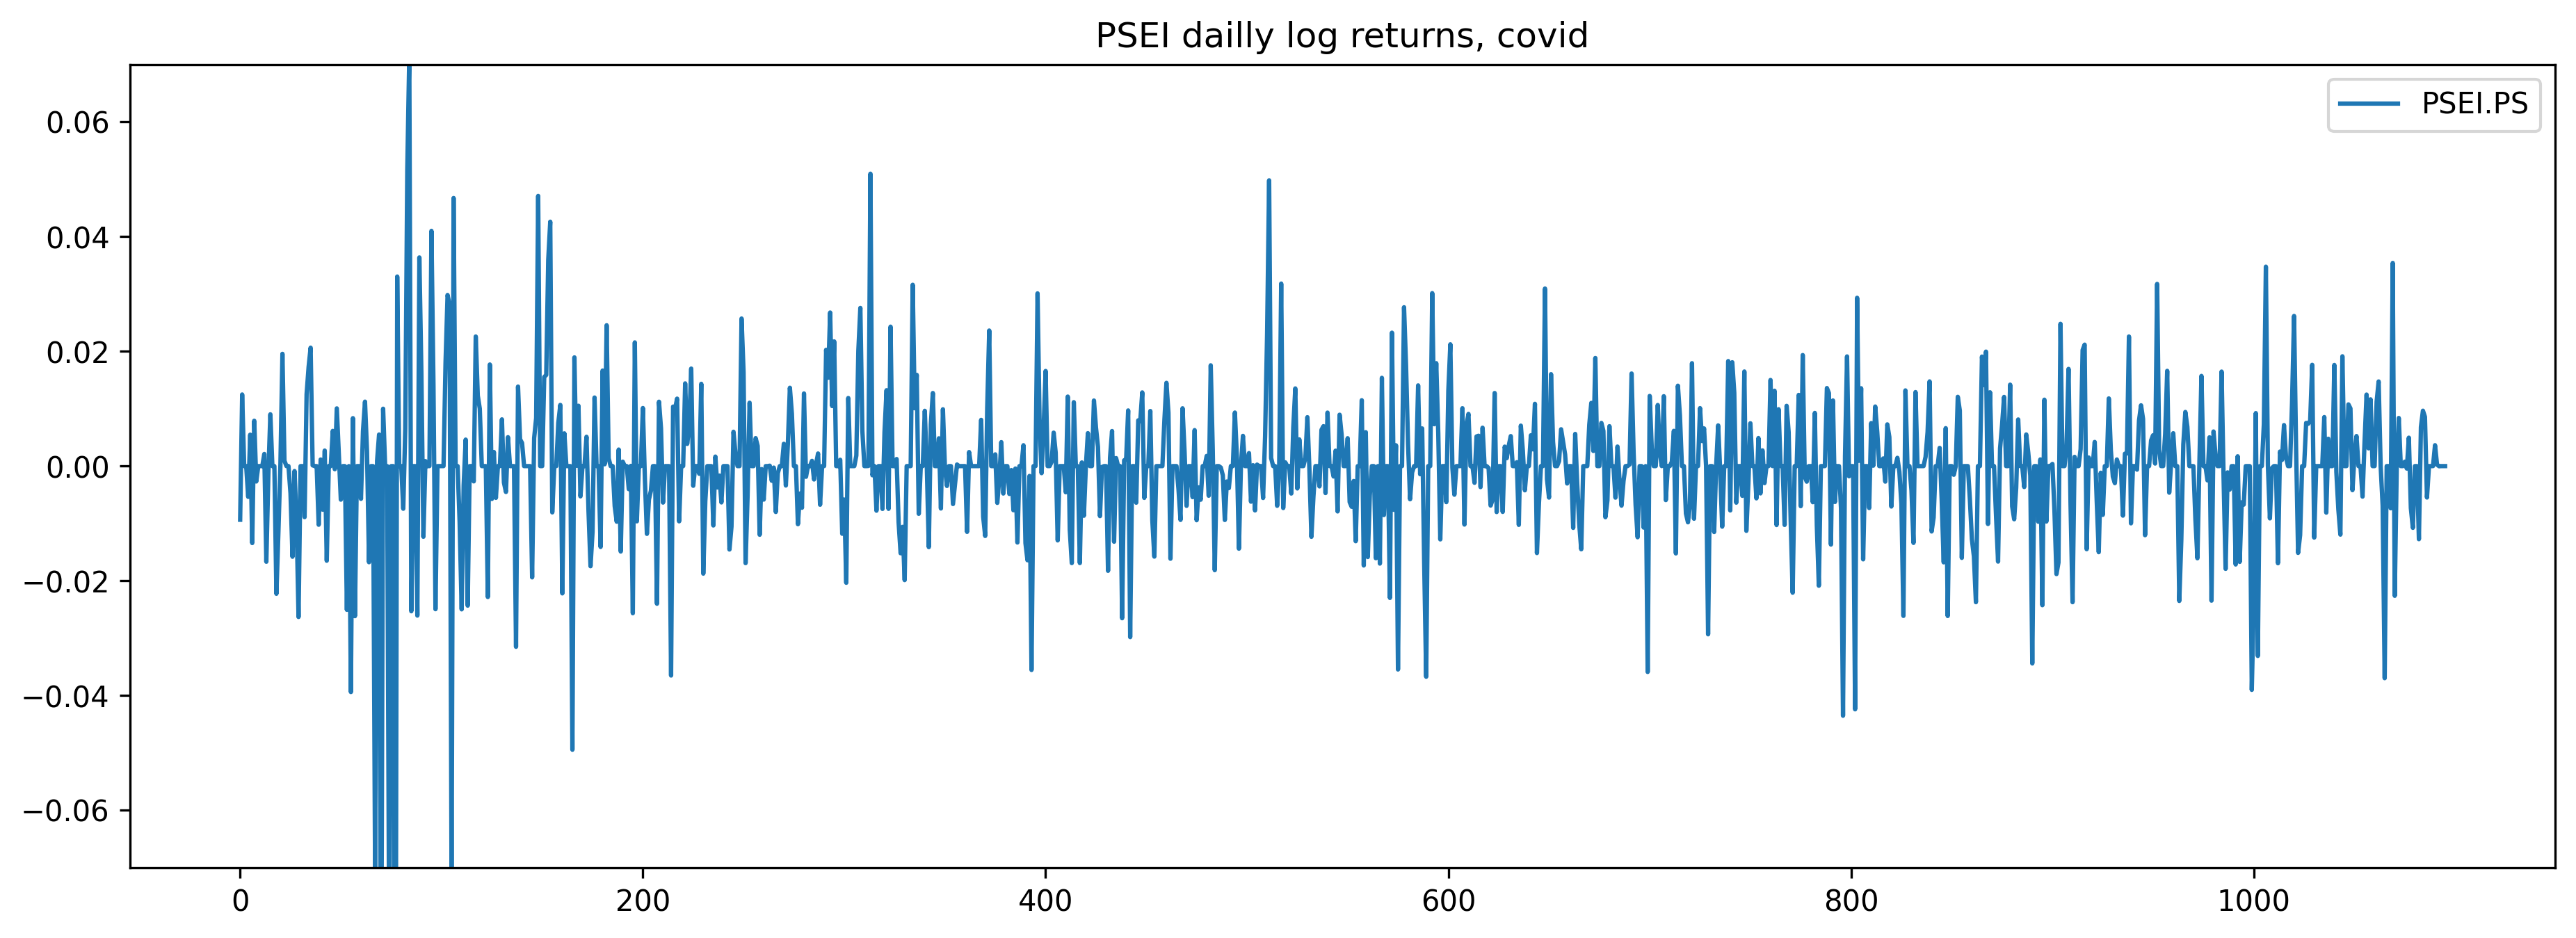

In [ ]:
DROPOUT = [0.1]
MODELS = ["transformer"]
PERIODS = {
    "train": ("2010-01-01", "2017-12-31"),
    "test": ("2018-01-01", "2019-12-31"),
    "gfc":("2008-01-01", "2008-12-31"),
    "covid":("2020-01-01", "2022-12-31")
 }

loss_metrics = dict()
for models in MODELS:
  for dropout in DROPOUT:
    for periods in PERIODS:
      start_date, end_date = PERIODS[periods]
      config = f"updated_{models}_batchsize-512_dropout-{dropout}"
      os.chdir(f"/content/drive/MyDrive/results/updated/{config}")
      # print(f"model_{config}.pth")
      model = torch.load(f"model_{config}.pth")
      df, loss = train.test(
          model=model,
          seq_len=128,
          horizon=1,
          batch_size=0,
          start_date=start_date,
          end_date=end_date,
          loss=nn.MSELoss(),
          lr=1e-4,
          scale_method="std",
          device=dev
      )
      plt.figure(figsize=(15, 5), dpi=300)
      plt.plot(df["y"])
      plt.legend(["PSEI.PS"])
      plt.axis(ymin=-0.07, ymax=0.07)
      plt.title(f"PSEI dailly log returns, {periods}")
      plt.savefig(f"{periods}_fig.png")
      # df.to_csv(f"stress_test_{periods}_{config}.csv")
      print(f"{periods} | {models} | {dropout} | {loss=}")